In [105]:
import urllib.request
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
from selenium import webdriver
import csv
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from ipywidgets import widgets, interactive

In [106]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# Fire Emblem: Heroes Character Analysis

## Introduction

In this project, we will be taking a look at character data from the popular mobile game *Fire Emblem: Heroes* available on iPhone and Android. Fire Emblem, a strategy RPG franchise developed by Intelligent System, added this mobile game to its list of entries following the popularity of recent titles *Fire Emblem: Awakening* and *Fire Emblem: Fates* for the 3DS. In this entry, you are in the position of a tactician, deploying up to four characters from the Fire Emblem Universe to do battle against the opposing enemy team. The game utilizes a rock-paper-scissors battle mechanic, with some weapons being superior to others. 

Like many popular mobile games, *Fire Emblem: Heroes* is a free-to-play Gacha game, where characters are drawn from a random pool, each with varying rarity and power. 


## Web-Scraping (Using Selenium)

We begin this project by obtaining the character data, using data hosted on gamepedia.com (I do not own the data). We will also be utilizing a Python package called Selenium to assist us with web-scraping duties. We will use the package to help us obtain information regarding how the characters are rated according to GamePress. We will use this data later on to build a prediction model.

To proceed, you will need to download a chromedriver. Google is a good place to start if you don't know how to do so.

### General Character Information

We will start off by getting general character information, which includes their name, their stats, what type of weapon they use, what their character type, and their tier according to the GamePress Offensive Tier List. 

In [107]:
browser = webdriver.Chrome("./chromedriver")

gg = ("https://gamepress.gg/feheroes/heroes")
browser.get(gg)
respData = browser.page_source
browser.close()
nsoup = BeautifulSoup(respData, 'html.parser')
n_table = nsoup.find("table", id = "hero-table-parent")

In [108]:
gpress = []
gpedia = []
tier = []
hp = []
attack = []
speed = []
defense = []
res = []
total = []
color = []
weap = []
mov = []
rar = []
urls = []

for group in n_table.findAll("tr")[1::3]:
    tier.append(group.findAll("td")[13].find(text = True))
    gpress.append(group.findAll("td")[0].findAll(text=True)[-1])
    hp.append(group.findAll("td")[2].findAll(text = True)[0])
    attack.append(group.findAll("td")[3].findAll(text = True)[0])
    speed.append(group.findAll("td")[4].findAll(text = True)[0])
    defense.append(group.findAll("td")[5].findAll(text = True)[0])
    res.append(group.findAll("td")[6].findAll(text = True)[0])
    total.append(group.findAll("td")[12].findAll(text = True)[0])
    color.append(group.attrs.get("class")[1])
    weap.append(group.attrs.get("class")[2])
    mov.append(group.attrs.get("class")[3])
    rar.append(group.attrs.get("class")[4])
    
    link = group.findAll("td")[0].find("a")["href"]
    url = "https://gamepress.gg" + link
    urls.append(url)

dfn = pd.DataFrame(gpress, columns = ["Name"])
dfn["Tier"] = tier
dfn["Color"] = color
dfn["Weapon"] = weap
dfn["MoveType"] = mov
dfn["Rarities"] = rar
dfn["HP"] = hp
dfn["Atk"] = attack
dfn["Spd"] = speed
dfn["Def"] = defense
dfn["Res"] = res
dfn["Total"] = total

In [109]:
dfn.head()

,Name,Tier,Color,Weapon,MoveType,Rarities,HP,Atk,Spd,Def,Res,Total
0,Abel,Tier 4,Blue,Lance,Cavalry,stars-3-4,39,33,32,25,25,154
1,Adrift Camilla,Tier 3,Red,Tome,Flying,stars-5-Star,36,37,30,17,30,150
2,Adrift Corrin (F),Tier 2,Green,Dragon,Infantry,stars-5-Star,41,31,37,32,27,168
3,Adrift Corrin (M),Tier 2,Blue,Dragon,Infantry,stars-5-Star,42,35,35,31,24,167
4,Alfonse,Tier 4,Red,Sword,Infantry,stars-4_Star_Story,43,35,25,32,22,157


In [110]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', 100):
#    display(dfn)

### Special Character Details

What we will do next is to parse through each character's stat page on GamePress to grab information that we believe is useful to help predict a character's tier. 

NOTE: Running the cell below will take quite a lot of time (when I last ran it, it took >30 minutes. So have something to do while you wait - like playing Fire Emblem: Heroes.

In [111]:
w_upgrades = []
personal = []
is_lm = []
origin = []

browse = webdriver.Chrome("./chromedriver")

for needed in urls:

    browse.get(needed)
    chardata = browse.page_source
    soupy = BeautifulSoup(chardata, 'html.parser')
    tab = soupy.find("table", id = "hero-details-table")
    weapinfo = soupy.find("div", id = "weapon-skills")
    
    #retrieves whether the character has weapon-refines
    if weapinfo.findAll("div", {"id": "weapon-upgrades-section"})[0].find(
        "div", {"class": "view-content"}) is not None:
        w_upgrades.append(True)
    else:
        w_upgrades.append(False)

    # retrieves whether the character has a personal, non-inheritable weapon
    i = 0
    per = False
    for item in weapinfo.findAll("div", {"class": "views-element-container"
        })[0].findAll("tr"):
        if i == 0:
            i += 1
            continue
        if not item.findAll("div"):
            continue
        if "Non-Inheritable skill" in item.findAll("div")[-1].get_text():
            per = True
            break
    if per is False:
        personal.append(False)
    else:
        personal.append(True)

    # get origin information
    try:
        orig = soupy.find("div", {"class": "field field--name-field-origin field--type-entity-reference field--label-hidden field__items"})
        origin.append(orig.findAll(text=True)[1])
    except AttributeError:
        origin.append("None")

    #gets information about whether character is legendary/mythic
    att = soupy.find("div", id = "hero-atts")
    is_lm.append(att.find("a", {"class": 
        "tipso-legendary tipso_style"}) is not None)

    
    
    #group.findAll("td")[12] is total
browse.quit()

In [112]:
dfn["Refines"] = w_upgrades
dfn["Personal Weapon"] = personal
dfn["Legendary/Mythic"] = is_lm
dfn["Origin"] = origin

In [113]:
dfn[dfn["Name"] == "Lucina"]

,Name,Tier,Color,Weapon,MoveType,Rarities,HP,Atk,Spd,Def,Res,Total,Refines,Personal Weapon,Legendary/Mythic,Origin
239,Lucina,Tier 2,Red,Sword,Infantry,stars-5_Legacy,43,34,36,25,19,157,True,True,False,Fire Emblem: Awakening


Another such important trait is whether a character is a particular unit class called a "refresher", which allows said character to "refresh" a character, granting them another move on your turn. This is quite the offensive boon, as giving your strongest character the opportunity to kill not one but TWO characters in your turn can turn the tide of battle in an instant.

In the game, there are two basic refreshing skills: dance, and sing. Thus, we will scrape for all characters who are capable of using either skill.

In [114]:
# to get list of refresher characters

refresh = []
dsurls = ["https://gamepress.gg/feheroes/command-skills/dance",
         "https://gamepress.gg/feheroes/command-skills/sing"]

brow = webdriver.Chrome("./chromedriver")
for lin in dsurls:
    brow.get(lin)
    ddata = brow.page_source
    dsoup = BeautifulSoup(ddata, "html.parser")
    since = dsoup.find("div", id = "block-gamepressbase-content")
    char = since.find("div", {"class": "views-element-container"}).findAll("a")
    for it in char[1::2]:
        refresh.append(it.get_text())
brow.quit()

In [115]:
ref = dfn["Name"].apply(lambda x: x in refresh)
dfn2 = dfn.copy()
dfn2["Refresher"] = ref

In [116]:
rar = []
ob = []
for row in dfn2["Rarities"]:
    st = []
    a = row.split("_")[0]
    if "Story" in row:
        ob.append("Story")
    elif "Grand_Hero_Battle" in row:
        ob.append("GHB")
    elif "Tempest_Trials" in row:
        ob.append("TT")
    elif "Enemy_Only" in row:
        ob.append("Enemy-Only")
    elif "Legacy" in row:
        ob.append("Legacy")
    else:
        ob.append("NA")
    for i in a.split("-"):
        if "3" in i or "4" in i or "5" in i:
            st.append(i)
    rar.append(st)

In [117]:
dfn2["Stars"] = rar
dfn2["Obtain"] = ob

In [118]:
#gets to see if the character has weapon-refines
if weapinfo.findAll("div", {"id": "weapon-upgrades-section"})[0].find(
    "div", {"class": "view-content"}) is not None:
    w_upgrades.append(True)
else:
    w_upgrades.append(False)
    #gpedia.append(tab.findAll("tr")[0].findAll(text = True)[2])

# gets info about personal weapon
i = 0
per = False
for item in weapinfo.findAll("div", {"class": "views-element-container"
    })[0].findAll("tr"):
    if i == 0:
        i += 1
        continue
    if "Non-Inheritable skill" in item.findAll("div")[-1].get_text():
        per = True
        break
if per is False:
    personal.append(False)
else:
    personal.append(True)

If we look carefully at the data, we will notice that some of the characters are missing origin information. Until Gamepress.gg fixes this, we will resort to doing this manually.

In [119]:
dfn2[dfn2["Origin"] == "None"]

,Name,Tier,Color,Weapon,MoveType,Rarities,HP,Atk,Spd,Def,Res,Total,Refines,Personal Weapon,Legendary/Mythic,Origin,Refresher,Stars,Obtain
35,Brave Lucina,Tier 1,Blue,Lance,Infantry,stars-5_Legacy,41,34,36,27,19,157,True,True,False,None,False,[5],Legacy
136,Halloween Dorcas,Tier 2,Green,Axe,Armored,stars-4-5_Event:_Tempest_Trials,49,41,25,37,21,173,True,False,False,None,False,"[4, 5]",TT
147,Halloween Nowi,Tier 3,Red,Tome,Flying,stars-5-Star,34,34,32,20,27,147,False,True,False,None,False,[5],NA
149,Halloween Sakura,Tier 4,Gray,Dagger,Infantry,stars-5-Star,33,32,34,14,34,147,False,False,False,None,False,[5],NA
153,Hector (LA),Tier 1,Green,Axe,Armored,stars-5-Star,50,38,21,40,24,173,False,True,False,None,False,[5],NA
184,Kaden,Tier 2,Green,Beast,Cavalry,stars-5-Star,38,32,36,25,25,156,False,False,False,None,False,[5],NA
192,Keaton,Tier 1,Red,Beast,Infantry,stars-5-Star,45,41,24,38,19,167,False,False,False,None,False,[5],NA
244,Lute,Tier 2,Blue,Tome,Infantry,stars-5_Legacy,33,36,32,16,34,151,True,True,False,None,False,[5],Legacy
246,Lyn (LA),Tier 2,Blue,Tome,Armored,stars-5-Star,37,31,36,27,34,165,True,False,False,None,False,[5],NA
280,New Year Azura,Tier 2,Green,Axe,Flying,stars-5-Star,37,30,35,22,26,150,True,False,False,None,True,[5],NA


In [120]:
#dfn2[dfn2["Name"] == "Brave Lucina"].Origin = "Fire Emblem: Awakening"
dfn2.loc[dfn2["Name"] == "Brave Lucina", "Origin"] = "Fire Emblem: Awakening"
dfn2.loc[dfn2["Name"] == "Halloween Dorcas", "Origin"] = "Fire Emblem: The Blazing Blade"
dfn2.loc[dfn2["Name"] == "Halloween Nowi", "Origin"] = "Fire Emblem: Awakening"
dfn2.loc[dfn2["Name"] == "Halloween Sakura", "Origin"] = "Fire Emblem Fates"
dfn2.loc[dfn2["Name"] == "Hector (LA)", "Origin"] = "Fire Emblem: The Blazing Blade"
dfn2.loc[dfn2["Name"] == "Kaden", "Origin"] = "Fire Emblem Fates"
dfn2.loc[dfn2["Name"] == "Keaton", "Origin"] = "Fire Emblem Fates"
dfn2.loc[dfn2["Name"] == "Lute", "Origin"] = "Fire Emblem: Sacred Stones"
dfn2.loc[dfn2["Name"] == "Lyn (LA)", "Origin"] = "Fire Emblem: The Blazing Blade"
dfn2.loc[dfn2["Name"] == "New Year Azura", "Origin"]= "Fire Emblem Fates"
dfn2.loc[dfn2["Name"] == "Performing Olivia", "Origin"] = "Fire Emblem: Awakening"
dfn2.loc[dfn2["Name"] == "Velouria", "Origin"] = "Fire Emblem Fates"

In [121]:
heroes = dfn2
heroes = heroes[heroes["Obtain"] != "Enemy-Only"]

In [122]:
heroes[["HP", "Atk", "Spd", "Def", "Res"]] = heroes[["HP", "Atk", "Spd", "Def", "Res"]].apply(pd.to_numeric)

## Data Visualization

In this section, we'll take a deeper look at the data that we just scraped to give ourselves a better idea of what we're working with. Some of the features that we'll be looking at are related to character statistics, weapon type, color, and game origin.

### Stat Distribution

In [123]:
# Make drop down for comparison of unit composition
sns.set()

cat_comp = widgets.Dropdown(
    options=["Weapon", "MoveType", "Color"],
    value="Weapon",
    description="Category:",
)

stat_comp = widgets.Dropdown(
    options=["HP", "Atk", "Spd", "Def", "Res"],
    value='HP',
    description='Stat:',
)

def plotit(cat, stat):
    plt.figure(figsize=(8, 5))
    sns.set(style="ticks")
    if cat == "Color":
        sns.violinplot(x= cat, y= stat, data=heroes, palette=["#3498db", "#fe2c54", "#12e193", "#bf77f6"])
    elif cat == "Weapon":
        sns.violinplot(x= cat, y= stat, data=heroes, palette="Set3")
    else:
        sns.violinplot(x= cat, y= stat, data=heroes, palette="hls")

interactive(plotit, cat = cat_comp, stat = stat_comp)

interactive(children=(Dropdown(description='Category:', options=('Weapon', 'MoveType', 'Color'), value='Weapon…

### Character Distribution

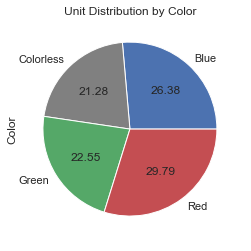

In [124]:
# See the number of characters for each color
sns.set()

colors = heroes.groupby(by="Color").agg(np.size).iloc[:, 6]
colors = colors.rename("Color")
colors.plot.pie(labels=['Blue', 'Colorless', 'Green', 'Red'], colors=['b', 'gray', 'g', 'r'], autopct='%.2f')
plt.title("Unit Distribution by Color")
plt.show()

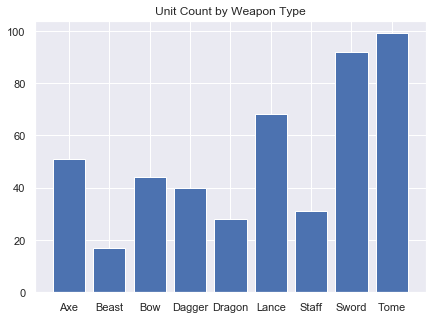

In [125]:
# See the number of characters for each weapon type
sns.set()
plt.figure(figsize=(7, 5))
plt.bar([0, 1, 2, 3, 4, 5, 6, 7, 8], heroes.groupby(by = "Weapon").agg(np.size).iloc[:, 0], align = "center")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], heroes.groupby(by = "Weapon").agg(np.size).index)
plt.title("Unit Count by Weapon Type")
plt.show()

We see that characters that use tomes are the most abundant in the game (barely beating out those who use swords). However, we should note that there are three different colors associated with tome users, while sword users are all red. Below we will show a distribution of the color of tome users.

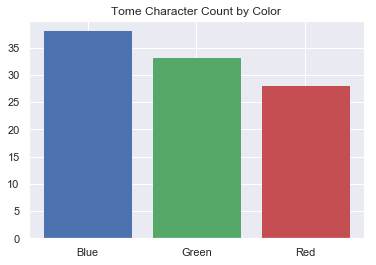

In [126]:
# Tome
tomebar = plt.bar([0, 1, 2], heroes.loc[heroes["Weapon"] == "Tome"].groupby(by = "Color").agg(np.size).iloc[:, 0], align = "center")
tomebar[np.where(heroes.loc[heroes["Weapon"] == "Tome"].groupby(by = "Color").agg(np.size).index.values == "Red")[0][0]].set_color('r')
tomebar[np.where(heroes.loc[heroes["Weapon"] == "Tome"].groupby(by = "Color").agg(np.size).index.values == "Blue")[0][0]].set_color('b')
tomebar[np.where(heroes.loc[heroes["Weapon"] == "Tome"].groupby(by = "Color").agg(np.size).index.values == "Green")[0][0]].set_color('g')
plt.xticks([0, 1, 2], heroes.loc[heroes["Weapon"] == "Tome"].groupby(by = "Color").agg(np.size).index)
plt.title("Tome Character Count by Color")
plt.show()

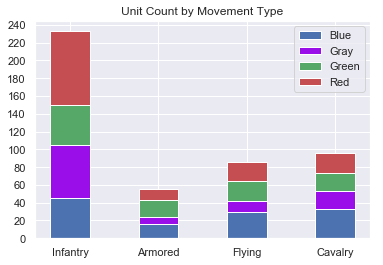

In [127]:
# See the number of characters for each movement type
sns.set()

mov_ty = ["Infantry", "Armored", "Flying", "Cavalry"]
inf = (heroes[heroes["MoveType"] == mov_ty[0]].groupby(by = "Color").agg(np.size).iloc[:, 0])
arm = (heroes[heroes["MoveType"] == mov_ty[1]].groupby(by = "Color").agg(np.size).iloc[:, 0])
fly = (heroes[heroes["MoveType"] == mov_ty[2]].groupby(by = "Color").agg(np.size).iloc[:, 0])
cav = (heroes[heroes["MoveType"] == mov_ty[3]].groupby(by = "Color").agg(np.size).iloc[:, 0])
inds = heroes[heroes["MoveType"] == mov_ty[0]].groupby(by = "Color").agg(np.size).index
inds

zos = np.array((inf[0], arm[0], fly[0], cav[0]))
ones = np.array((inf[1], arm[1], fly[1], cav[1]))
twos = np.array((inf[2], arm[2], fly[2], cav[2]))
tres = np.array((inf[3], arm[3], fly[3], cav[3]))

ind = np.arange(4)    
width = 0.45      

p1 = plt.bar(ind, zos, width, color = "b")
p2 = plt.bar(ind, ones, width,  bottom=zos, color = "xkcd:violet")
p3 = plt.bar(ind, twos, width,  bottom= zos + ones, color = "g")
p4 = plt.bar(ind, tres, width, bottom = zos + ones + twos, color = "r")

plt.title("Unit Count by Movement Type")
plt.xticks(ind, ("Infantry", "Armored", "Flying", "Cavalry"))
plt.yticks(np.arange(0, np.sum(inf) + 10, 20))
plt.legend((p1[0], p2[0], p3[0], p4[0]), (inds))

plt.show()

#heroes.groupby(by = "Movement Type").agg(np.size).iloc[:, 0].groupby(by = "Color").agg(np.size).iloc[:, 0]

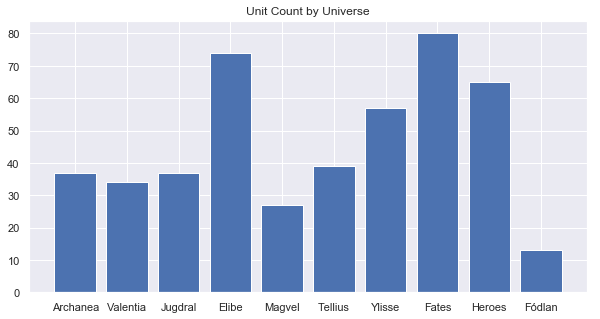

In [128]:
# See the number of characters for each universe
sns.set()

Universes = []

Archanea = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Mystery of the Emblem"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: Shadow Dragon and the Blade of Light"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: New Mystery of the Emblem"])
Valentia = len(heroes.loc[heroes["Origin"] == "Fire Emblem Echoes"])
Jugdral = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Genealogy of the Holy War"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: Thracia 776"])
Elibe = len(heroes.loc[heroes["Origin"] == "Fire Emblem: The Blazing Blade"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: The Binding Blade"])
Magvel = len(heroes.loc[heroes["Origin"] == "Fire Emblem: The Sacred Stones"])
Tellius = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Path of Radiance"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: Radiant Dawn"])
Ylisse = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Awakening"])
Fates = len(heroes.loc[heroes["Origin"] == "Fire Emblem Fates"])
Heroes = len(heroes.loc[heroes["Origin"] == "Fire Emblem Heroes"])
threeH = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Three Houses"])
     
Universes.append(Archanea)
Universes.append(Valentia)
Universes.append(Jugdral)
Universes.append(Elibe)      
Universes.append(Magvel)
Universes.append(Tellius)
Universes.append(Ylisse)
Universes.append(Fates)
Universes.append(Heroes)
Universes.append(threeH)

plt.figure(figsize=(10, 5))
plt.bar(np.arange(10), Universes, align = "center")
plt.xticks(np.arange(10), ["Archanea", "Valentia", "Jugdral", "Elibe", "Magvel", "Tellius", 
                          "Ylisse", "Fates", "Heroes", "Fódlan"])
plt.title("Unit Count by Universe")
plt.show()

In [145]:
len(heroes[heroes["Origin"] == "Fire Emblem Heroes"])

65

The universes above correspond to the following games:

Archanea: _Fire Emblem: Shadow Dragon_ and _Fire Emblem: Mystery of the Emblem_  
Valentia: _Fire Emblem Gaiden_ / _Fire Emblem Echoes: Shadows of Valentia_  
Jugdral: _Fire Emblem: Geneology of the Holy War_ and _Fire Emblem Thracia 776_  
Elibe: _Fire Emblem: Binding Blade_ and _Fire Emblem: Blazing Sword_ (known as _Fire Emblem_ in the US)  
Magvel: _Fire Emblem: Sacred Stones_  
Tellius: _Fire Emblem: Path of Radiance_ and _Fire Emblem: Radiant Dawn_  
Ylisse: _Fire Emblem: Awakening_  
Fates: _Fire Emblem: Fates_  
Heroes: _Fire Emblem: Heroes_  
Fódlan: _Fire Emblem: Three Houses_  

We can see that certain universes have noticeably higher representation in the game. Fates characters make up about close to 20% of the current total character count. Elibe (Blazing Sword and Binding Blade) and Awakening make up the rest of the top three. It is likely that popularity of the entries is related to character representation.

Interestingly, it appears that Gamepress.gg records spin-off characters as having Fire Emblem Heroes as its origin, such as Legendary Hector and Halloween Mia. We will fix this later on.

Fire Emblem: Three Houses was just recently released in July 2019, so it is likely more characters will be rolled out from that entry soon enough.

## Save to CSV

The cell below will save the data that we've scraped and processed into a .csv file that can be used for future analysis.

In [146]:
heroes.to_excel("hero_data.xlsx", encoding='utf-8', index=False)
#heroes["Name"].to_excel("tier_list.xlsx", encoding='utf-8', header = True)